In [1]:
"""
Data visualization
Author: Xionghui Xu
Date: July 11, 2025
"""
import os
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import rioxarray as rxr
from concurrent.futures import ThreadPoolExecutor
import warnings
from pathlib import Path

In [2]:
#### Here we set the configuration
ROOT_DIR = Path("../data").resolve()
region = [-180,180,-60,90]
data_path = ROOT_DIR
shp_path = ROOT_DIR / "shp"
print(data_path)
print(shp_path)

/tera04/zhwei/xionghui/bedrock/data
/tera04/zhwei/xionghui/bedrock/data/shp


# Visualization

## 1. Data Export

In [ ]:
def load_and_flatten_data(file_name, variable_name, index=None, path='data/run/'):
    try:
        with nc.Dataset(f"{path}{file_name}.nc4") as dataset:
            data = dataset[variable_name][index, :, :].flatten() if index is not None else dataset[variable_name][:, :].flatten()
        return data
    except Exception as e:
        warnings.warn(f"Error loading {file_name}.nc4 or variable {variable_name}: {e}")
        return None

def load_lat_lon(data_path):
    try:
        with nc.Dataset(f"{data_path}masking_criteria/mask_combine_all.nc4") as dataset:
            lat = dataset['lat'][:]
            lon = dataset['lon'][:]
            # Use meshgrid for efficient grid creation
            lon_grid, lat_grid = np.meshgrid(lon, lat)
            return lat_grid.ravel(), lon_grid.ravel()
    except Exception as e:
        warnings.warn(f"Error loading lat/lon from masking_criteria/mask_combine_all.nc4: {e}")
        return None, None

def load_all_data(file_variable_list, data_path='data/run/'):
    # Initialize DataFrame
    df = pd.DataFrame()

    # Load lat/lon first
    lat, lon = load_lat_lon(data_path)
    if lat is None or lon is None:
        raise RuntimeError("Failed to load latitude/longitude data")
    df['lat'] = lat
    df['lon'] = lon

    # Load other variables
    for file_name, variable_name, index in file_variable_list:
        data = load_and_flatten_data(file_name, variable_name, index, data_path)
        if data is not None:
            df[file_name] = data

    return df

# Configuration
data_path = 'data/run/'
file_variable_list = [
    ('masking_criteria/mask_combine_all', 'Band1', None),
    ('Dbedrock_Frequency', 'Dbedrock', None),
    ('Sbedrock', 'Band1', None),
    ('Area', 'area', None),
    ('Koppen', 'Band1', None),
    ('IGBP', 'LC', 0),
]

# Load all data
try:
    df = load_all_data(file_variable_list, data_path)

    area_sum = df['Area'].sum() / 1e12
    df = df[df['masking_criteria/mask_combine_all'] == 1]
    area_mask_sum = df['Area'].sum() / 1e12
    area_tropics = df[(df['lat'] > -23.5) & (df['lat'] < 23.5)]['Area'].sum() / 1e12
    area_subarctic = df[(df['lat'] > 50) & (df['lat'] < 66.5)]['Area'].sum() / 1e12

    print(f"Total area: {area_sum:.4f} million km²")
    print(f"Masked area: {area_mask_sum:.4f} million km²")
    print(f"Tropical area (-23.5° to 23.5°): {area_tropics:.4f} million km²")
    print(f"Subarctic area (50° to 66.5°): {area_high_lat:.4f} million km²")
    df = df.drop(columns=['masking_criteria/mask_combine_all'])

except Exception as e:
    print(f"Error processing data: {e}")

df

Total area: 510.0997 million km²
Masked area: 24.8318 million km²
Tropical area (-23.5° to 23.5°): 11.3280 million km²
Error processing data: name 'area_high_lat' is not defined


lat        lon  masking_criteria/mask_combine_all  \
708161369  -55.847915 -67.627077                                1.0   
708161370  -55.847915 -67.622911                                1.0   
708161371  -55.847915 -67.618744                                1.0   
708161372  -55.847915 -67.614577                                1.0   
708161373  -55.847915 -67.610411                                1.0   
...               ...        ...                                ...   
3586500782  82.960426 -26.739575                                1.0   
3586500783  82.960426 -26.735409                                1.0   
3586500784  82.960426 -26.731242                                1.0   
3586500785  82.960426 -26.727075                                1.0   
3586500786  82.960426 -26.722909                                1.0   

            Dbedrock_Frequency   Sbedrock           Area  Koppen  IGBP  
708161369                  1.0   0.236460  120515.621801      29     1  
708161370                  1.0   0.279453  120515.621801      29     1  
708161371                  1.0   0.322446  120515.621801      29     1  
708161372                  1.0   0.365440  120515.621801      29     4  
708161373                  1.0   0.408433  120515.621801      29     4  
...                        ...        ...            ...     ...   ...  
3586500782                 1.0  39.301605   26309.225697      29     1  
3586500783                 1.0  39.884819   26309.225697      29     1  
3586500784                 1.0  40.468037   26309.225697      29     1  
3586500785                 1.0  41.051250   26309.225697      29     1  
3586500786                 1.0  41.634464   26309.225697      29     1  

[157069431 rows x 8 columns]

## 2. Plotting

In [8]:
%matplotlib inline

import geopandas as gpd
from pylab import rcParams
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
pd.set_option('display.max_columns', None)

params = {'font.family': 'Arial',
          'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

font_properties = fm.FontProperties(family='Arial', weight='bold')
size = 0.0005

In [10]:
df1 = df.copy()
shp = gpd.GeoDataFrame.from_file(shp_path+'World_CN/ne_10m_admin_0_countries_chn.shp')

### 2.1 Fig. 2a

In [11]:
def draw(df1,name,level,cmap):
    df1 = df1[df1[name[0]] > 0]

    fig = plt.figure(figsize=(12, 6), dpi=300)

    fig.subplots_adjust(left=0.05, right=0.98, 
                    bottom=0.14, top=0.95, hspace=0.25) 
        
    #Create a subgraph grid with 2 rows and 3 columns
    gs = GridSpec(2, 6)
    ax = fig.add_subplot(gs[:, :], projection=ccrs.PlateCarree())

    # Set drawing mode(note:extent's lat from positive to negative)
    img = ax.scatter(df1['lon'], df1['lat'], c=df1[name[0]], 
                    s=size, linewidths=0, edgecolors="k", 
                    cmap=cmap, zorder=1, vmin=level[0], vmax=level[-1])

    for spine in ax.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(0)  

    ax.set_xlim(region[0], region[1])
    ax.set_ylim(region[2], region[3])

    # coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='0.6', facecolor='none')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
    ax.add_feature(cfeature.LAND, facecolor='0.95')
    # ax.add_feature(coastline, linewidth=0.6)
    ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
    ax.add_feature(rivers, linewidth=0.8)
    # ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent(region)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # ax.grid(ls = "--", lw = 0.25, color = "#4E616C")

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linestyle='--', color='#4E616C')   
    gl.xlocator = ticker.FixedLocator(np.arange(-120, 181, 60)) 
    gl.ylocator = ticker.FixedLocator(np.arange(-60, 91, 30))    

    # From the bottom left corner x, y, width, height
    custom_ticks = [0, 100, 200, 300, 400]
    # cbar_ax = fig.add_axes([0.4, 0.14, 0.4, 0.03], frameon = False) 
    cbar_ax = fig.add_axes([0.1, 0.06, 0.8, 0.04], frameon = True) 
    cb = fig.colorbar(img, 
                    drawedges=True,
                    ticks=level, 
                    cax=cbar_ax, 
                    orientation='horizontal',
                    spacing='uniform')

    cb.ax.tick_params(labelsize=20)
    cb.ax.yaxis.set_tick_params(direction='out', width=1.5)
    # for label in cb.ax.get_xticklabels() + cb.ax.get_yticklabels():
    #     label.set_fontproperties(font_properties)
    cb.set_label(f'{name[3]}', fontsize=30, fontweight='bold')

    cb.outline.set_visible(True)
    cb.outline.set_edgecolor('#333333')
    cb.outline.set_linewidth(2)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_2391421/1473931724.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


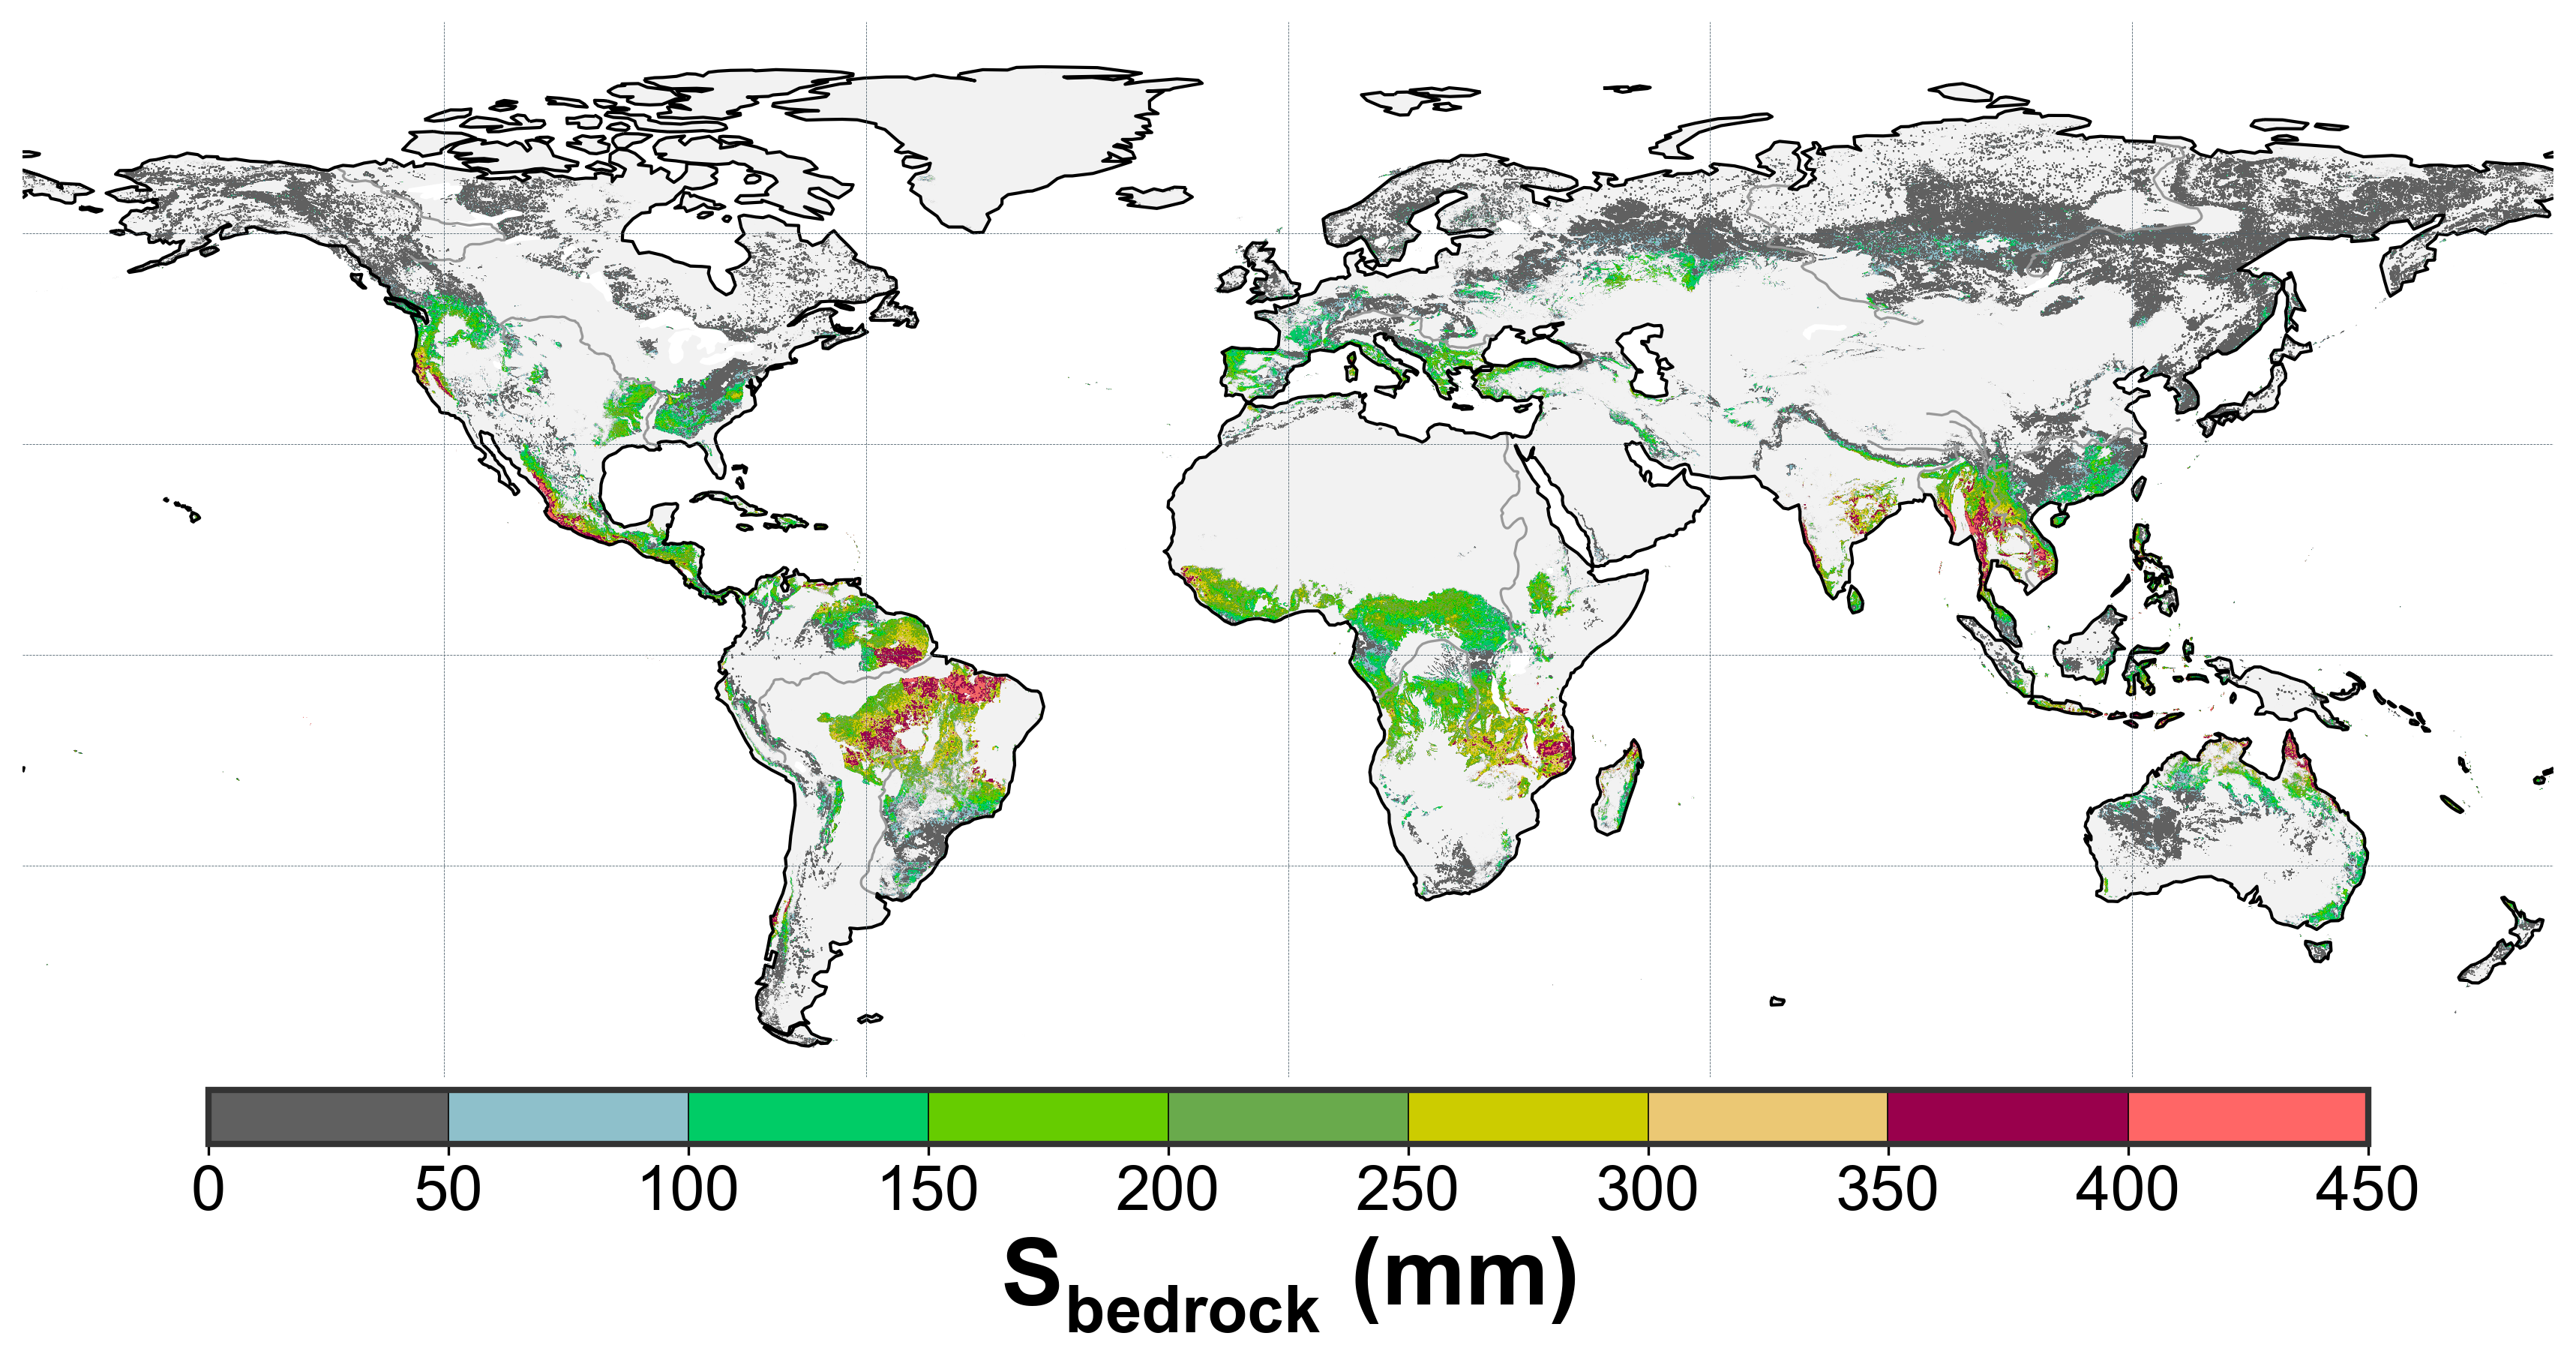

In [12]:
rgb_list = ['#606060','#8ec0cb','#00CC66','#66CC00',
                                '#69aa4c','#CCCC00','#ebc874','#99004C','#FF6666']

name = [f'Sbedrock', 'Sbedrock', 'Sbedrock', '$S_{bedrock}$ (mm)']
level = np.arange(0,500,50)
cmap = colors.ListedColormap(rgb_list)
draw(df1,name,level,cmap)

In [13]:
def plot_line(title, ax, x, y1, y2, color):
    ax.grid(ls = "--", lw = 0.25, color = "#4E616C")
    # y1 = y1.rolling(window = 5, min_periods = 0).mean()
    # y2 = y2.rolling(window = 20, min_periods = 0).mean()

    ax.plot(x, y1, mfc = "white",lw = 2, ms = 2, color = color[0], label=title[1])

    ax.set_ylim(0)
    
    if x.min() < -90:
        interval = 60
        xmin,xmax = -180,180
    else:
        interval = 30
        xmin,xmax = -90,90
    xlevel = np.arange(xmin, xmax+interval, interval)
    xlevel2 = np.arange(xmin+interval, xmax, interval)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))
    ax.xaxis.set_ticks(xlevel2)

    ticks_degrees = xlevel2
    if x.min() < -90:
        tick_labels = [f"{abs(int(deg))}°{'E' if deg > 0 else ('W' if deg < 0 else '')}" for deg in ticks_degrees]
    else:
        tick_labels = [f"{abs(int(deg))}°{'N' if deg > 0 else ('S' if deg < 0 else '')}" for deg in ticks_degrees]
    ax.xaxis.set_ticklabels(tick_labels)
    ax.xaxis.set_tick_params(length = 2, color = "#4E616C", labelcolor = "#4E616C", labelsize = 24)
    ax.set_xlim(xlevel[0],xlevel[-1])
    

    if x.min() < -90:
        interval = 10
    else:
        interval = 20
    y1level = np.arange(0,y1.max()+interval,interval)
    # print(y1level)
    y1level2 = np.arange(interval,y1.max(),interval)
    ax.set_ylim(0, y1level[-1])
    ax.yaxis.set_ticks(y1level2)
    ax.yaxis.set_ticklabels(int(j) for j in y1level2)
    ax.yaxis.set_tick_params(length = 2, color = color[0], labelcolor = color[0], labelsize = 24)

    ax2 = ax.twinx()

    interval = 150
    y2level = np.arange(0, y2.max() + interval, interval)
    y2level2 = np.arange(interval,y2.max(),interval)
    
    ax2.set_xlim(xlevel[0],xlevel[-1])
    ax2.set_ylim(0, y2level[-1])
    ax2.yaxis.set_ticks(y2level2)
    ax2.yaxis.set_ticklabels(int(j) for j in y2level2)
    ax2.yaxis.set_tick_params(length=2, color=color[1], labelcolor=color[1], labelsize=24)
    ax2.plot(x, y2, mfc = "white",lw = 2, ms = 2, color = color[1], label=title[1])

    
    # ax.axvline(x=0, color="#4E616C",lw = 0.2, linestyle='-')
    ax.spines["bottom"].set_edgecolor("#4E616C")

    for spine in ax.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(0)  
    
    
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')  
        spine.set_linewidth(0) 



In [14]:
df_area = df.copy()

/tmp/ipykernel_2391421/1570414613.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


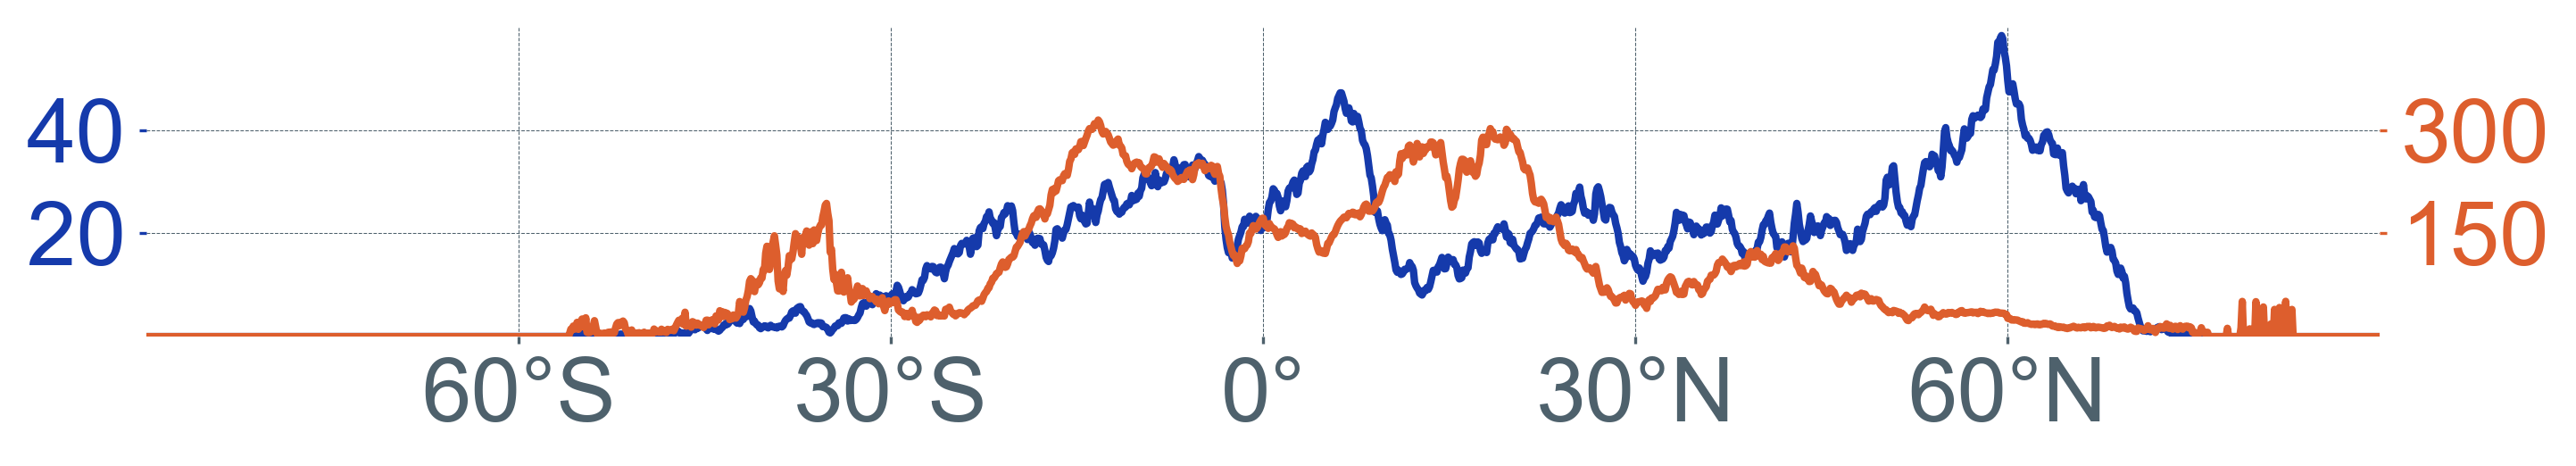

In [15]:
fig = plt.figure(figsize=(18, 4), dpi=300)
fig.subplots_adjust(left=0.05, right=0.98, 
                bottom=0.14, top=0.95, hspace=0.8) 
gs = GridSpec(2, 48)

ax1 = fig.add_subplot(gs[0, :24])
df_area = df.copy()
lat = pd.Series((np.arange(-90, 90, 0.1)).round(2))
lat_area = df_area.groupby('lat')['Area'].sum().div(1e9)
lat_area_0p1 = lat_area.groupby(np.floor(lat_area.index * 10) / 10).sum()
lat_Sb = df_area.groupby('lat')['Sbedrock'].mean()
lat_Sb_0p1 = lat_Sb.groupby(np.floor(lat_Sb.index * 10) / 10).mean()
lat_area_df = lat_area_0p1.reindex(lat, fill_value=0)
lat_Sb_df = lat_Sb_0p1.reindex(lat, fill_value=0)
plot_line(["Area (\u00D7$10^3$$km^2$)","$S_{{bedrock}}$ (mm)"], 
ax1, lat_area_df.index, lat_area_df, lat_Sb_df, color = ["#153aab","#dd5e2d"])
color = ["#153aab","#fdcf41"]

fig.patch.set_alpha(0)
plt.tight_layout()
# plt.savefig(f"../fig/all/l2_lat.eps",dpi=500, bbox_inches='tight')
plt.show()

/tmp/ipykernel_2391421/2595651261.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


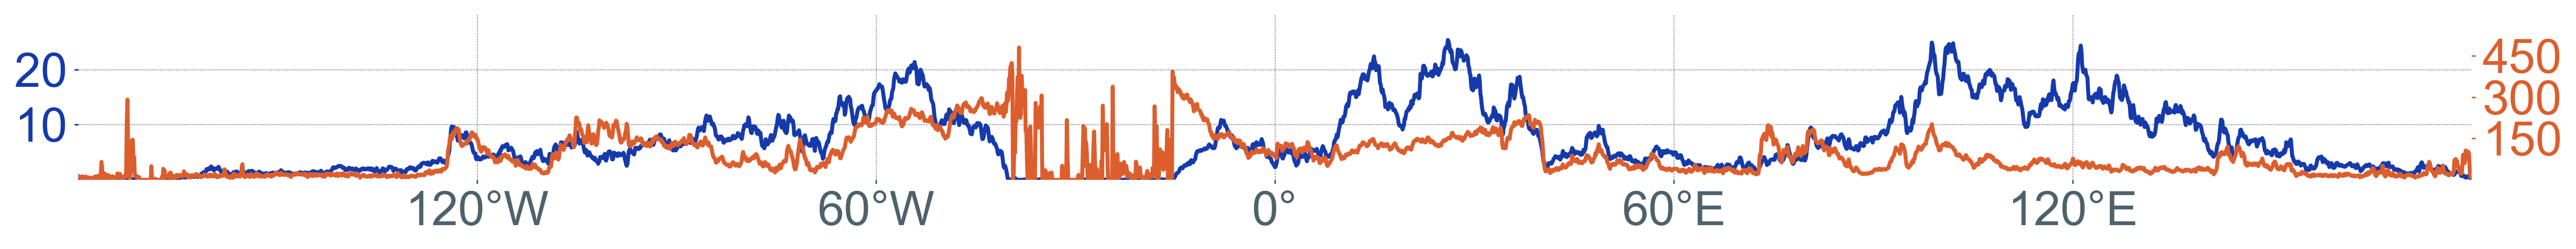

In [16]:
fig = plt.figure(figsize=(18, 4), dpi=300)
fig.subplots_adjust(left=0.05, right=0.98, 
                bottom=0.14, top=0.95, hspace=0.8) 
gs = GridSpec(2, 48)

ax2 = fig.add_subplot(gs[1, :])
lon = pd.Series((np.arange(-180, 180, 0.1)).round(2))
lon_area = df_area.groupby('lon')['Area'].sum().div(1e9)
lon_area_0p1 = lon_area.groupby(np.floor(lon_area.index * 10) / 10).sum()
lon_Sb = df_area.groupby('lon')['Sbedrock'].mean()
lon_Sb_0p1 = lon_Sb.groupby(np.floor(lon_Sb.index * 10) / 10).mean()
lon_area_df = lon_area_0p1.reindex(lon, fill_value=0)
lon_Sb_df = lon_Sb_0p1.reindex(lon, fill_value=0)
plot_line(["Area (\u00D7$10^3$$km^2$)","$S_{{bedrock}}$ (mm)"], 
ax2, lon_area_df.index, lon_area_df, lon_Sb_df, color = ["#153aab","#dd5e2d"])

fig.patch.set_alpha(0)
plt.tight_layout()
# plt.savefig(f"../fig/all/l2_lon.eps",dpi=500, bbox_inches='tight')
plt.show()

### 2.2 Fig. 3a

In [17]:
def draw(df1,name,level,cmap):
    df1 = df1[df1[name[0]] > 0]

    fig = plt.figure(figsize=(12, 6), dpi=300)

    fig.subplots_adjust(left=0.05, right=0.98, 
                    bottom=0.14, top=0.95, hspace=0.25) 
        
    #Create a subgraph grid with 2 rows and 3 columns
    gs = GridSpec(2, 6)
    ax = fig.add_subplot(gs[:, :], projection=ccrs.PlateCarree())

    # Set drawing mode(note:extent's lat from positive to negative)
    img = ax.scatter(df1['lon'], df1['lat'], c=df1[name[0]], 
                    s=size, linewidths=0, edgecolors="k", 
                    cmap=cmap, zorder=1, vmin=level[0], vmax=level[-1])

    for spine in ax.spines.values():
        spine.set_linewidth(0)  

    ax.set_xlim(region[0], region[1])
    ax.set_ylim(region[2], region[3])

    # coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m', edgecolor='0.6', facecolor='none')
    rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '110m', edgecolor='0.6', facecolor='none')
    ax.add_feature(cfeature.LAND, facecolor='0.95')
    # ax.add_feature(coastline, linewidth=0.6)
    ax.add_feature(cfeature.LAKES, alpha=1, facecolor='white', edgecolor='white')
    ax.add_feature(rivers, linewidth=0.8)
    # ax.gridlines(draw_labels=False, linestyle=':', linewidth=0.7, color='grey', alpha=0.8)

    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent(region)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    plt.tight_layout()
    plt.show()
    


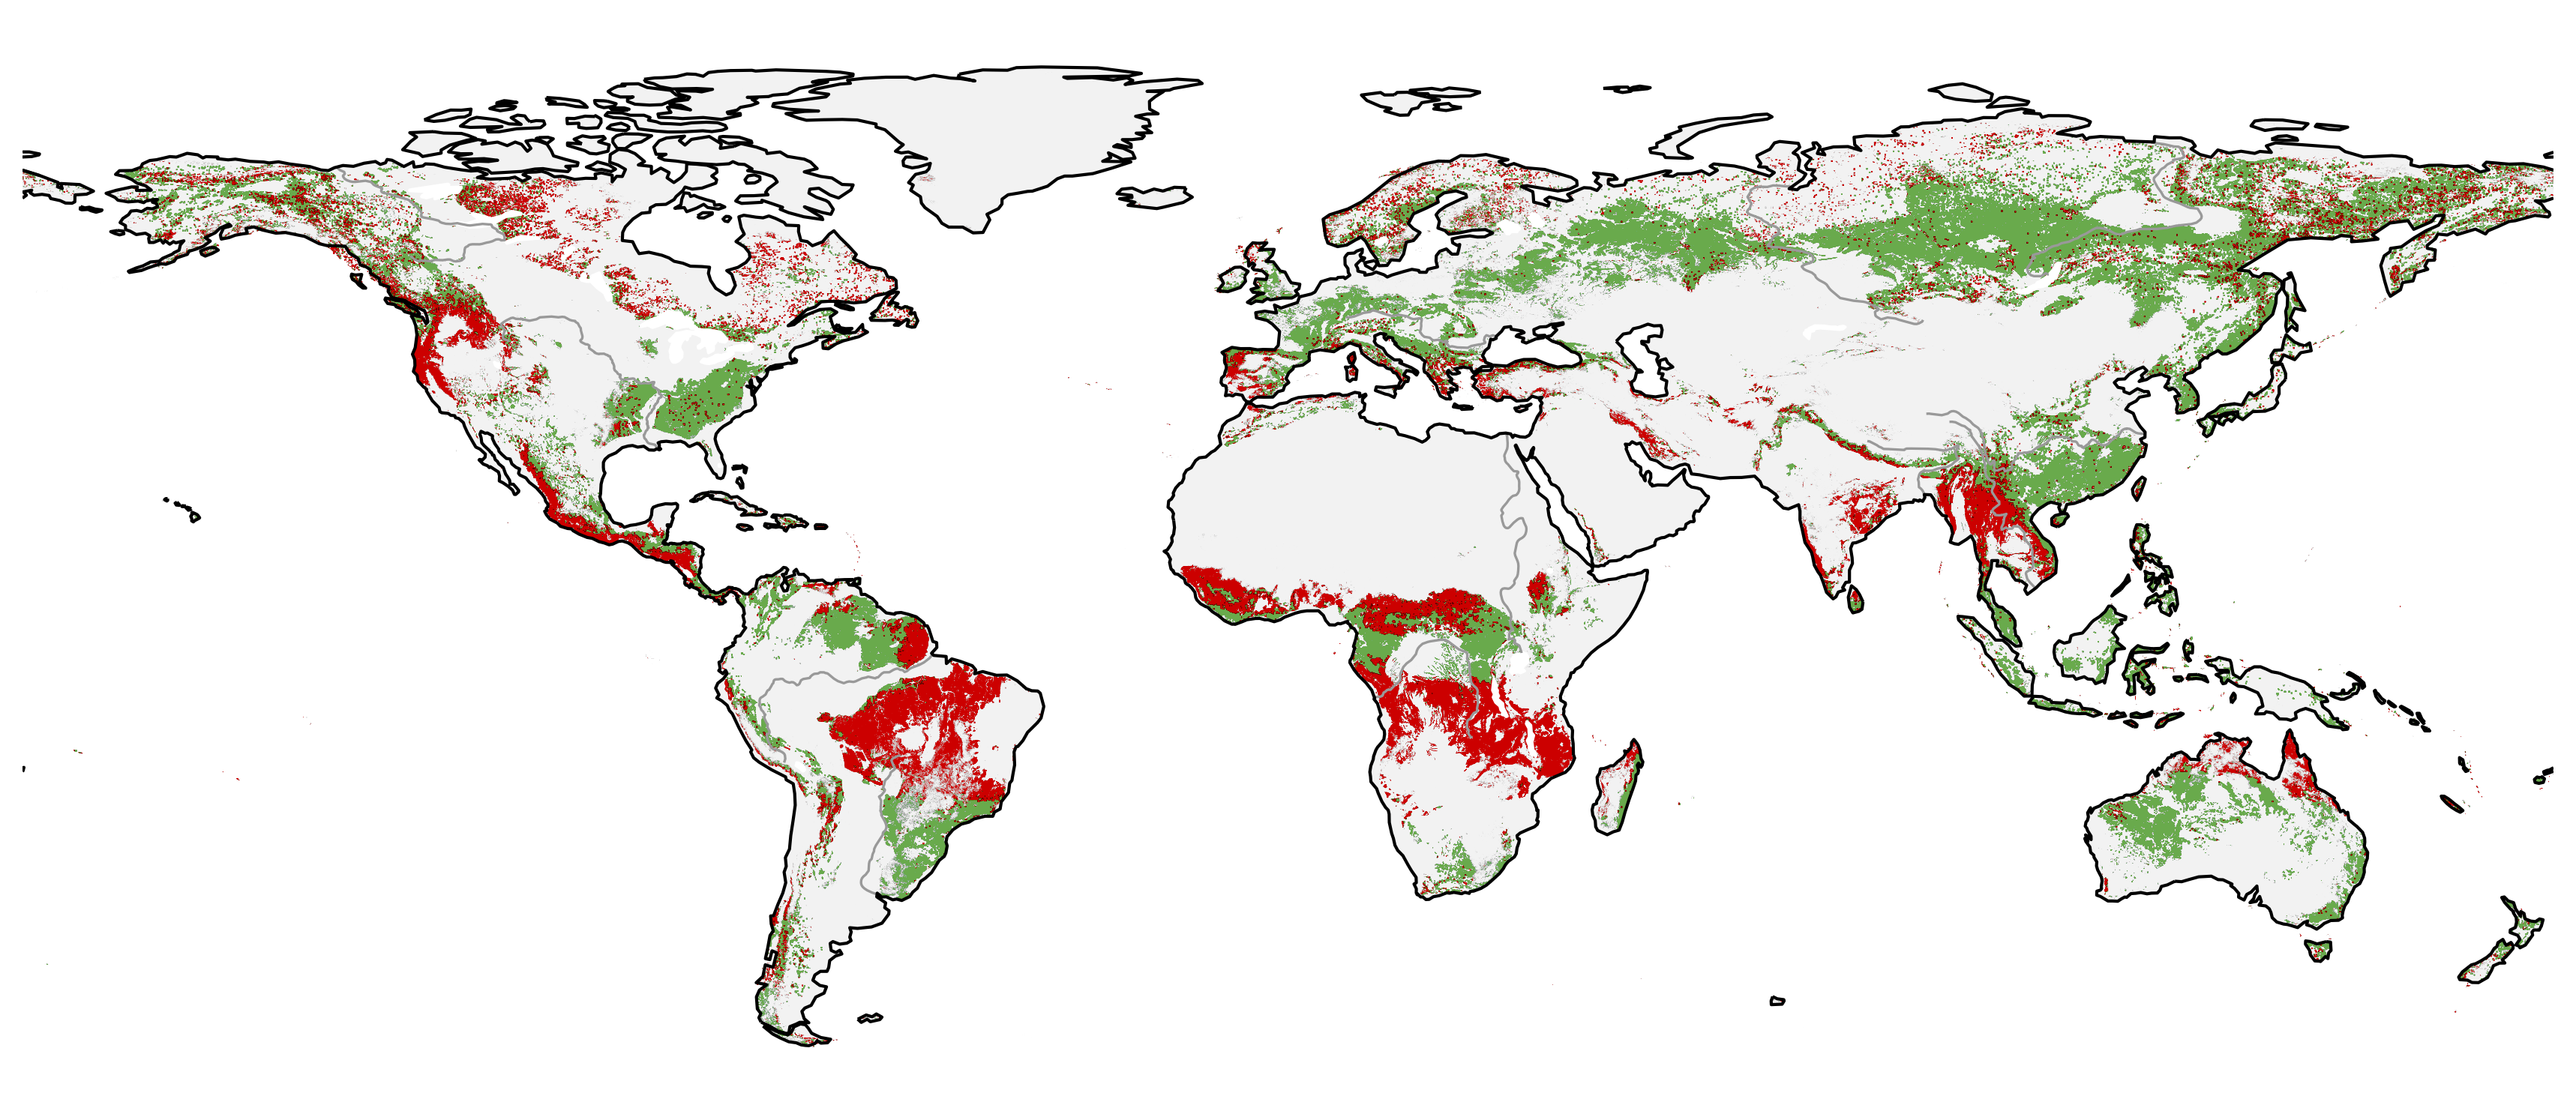

In [18]:
rgb_list = ['#CC0000','#69aa4c']

name = ['Dbedrock_Frequency', 'Dbedrock', 'DF', 'Dbedrock Frequency']
level = np.arange(0.5, 4, 1)
cmap = colors.ListedColormap(rgb_list)
draw(df1,name,level,cmap)

### 2.3 Figs. 3b, 3c

In [25]:
## group together Koppen first and second letter groups
df_Koppen = df.copy()
df_Koppen = df_Koppen[df_Koppen['Koppen'] > 0]
df_Koppen = df_Koppen[df_Koppen['Koppen'] < 29]
df_Koppen['Koppen_Together'] = df_Koppen['Koppen'].replace(to_replace=[5, 7, 9, 10, 12, 13, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28], value=[4, 6, 8, 8, 11, 11, 14, 14, 17, 17, 17, 21, 21, 21, 25, 25, 25])

# Grouped first and second letters of koppen climate types:
#5 to 4
#7 to 6
#9, 10 to 8
#13, 12 to 11
#16, 15 to 14
#20, 19, 18 to 17
#24, 23, 22 to 21
#28, 27, 26 to 25
#29 alone

koppen_area_sum = df_Koppen.groupby('Koppen_Together')['Area'].sum().sort_values(ascending=False)

df_Koppen_reorder = df_Koppen.merge(koppen_area_sum, how='left', on='Koppen_Together', suffixes=('', '_sum'))
df_Koppen_sorted = df_Koppen_reorder.sort_values(by='Area_sum', ascending=False)
df_Koppen_sorted.reset_index(drop=True, inplace=True)

# Setup dataframe with all Koppen Groups, Values, and Colors
# KoppenColor = ['#0000FE','#0077FF','#46A9FA','#FE0000',
#                '#FE9695','#F5A301','#FFDB63','#FDFD45',
#                '#C6C700','#96FF96','#63C764','#329633',
#                '#C6FF4E','#66FF33','#33C701','#FF00FE',
#                '#C600C7','#963295','#966495','#ABB1FF',
#                '#5A77DB','#4C51B5','#320087','#18DCDC',
#                '#38C7FF','#007E7D','#00455E','#B2B2B2',
#                '#686868']
KoppenColor =   ['#0000FF', '#0078FF', '#46AAFA', '#FF0000', 
                 '#FF9696', '#F5A500', '#FFDC64', '#FFFF00', 
                 '#C8C800', '#969600', '#96FF96', '#64C864', 
                 '#329632', '#C8FF50', '#64FF32', '#32C800',  
                 '#FF00FF', '#C800C8', '#963296', '#966496', 
                 '#AAAFFF', '#5A78DC', '#4B50B4', '#320087', 
                 '#00FFFF', '#37C8FF', '#007D7D', '#00465F', 
                 '#B3B3B3', '#666666']
KoppenList = ['Tropical Rainforest (Af)','Tropical Monsoon (Am)','Tropical Savanna (Aw)',
              'Desert (BWh)','Arid (BWk)',
              'Semi Arid (BSh)','Semi Arid (BSk)',
              'Mediterranean (Csa)','Mediterranean (Csb)','Mediterranean (Csc)',
              'Humid Subtropical (Cwa)','Oceanic (Cwb)','Ocanic (Cwc)',
              'Humid Subtropical (Cfa)','Oceanic (Cfb)','Oceanic (Cfc)',
              'Humid Continental (Dsa)','Humid Continental (Dsb)','Subarctic (Dsc)','Subarctic (Dsd)',
              'Humid Continental (Dwa)','Humid Continental (Dwb)','Subarctic (Dwc)','Subarctic (Dwd)',
              'Humid Continental (Dfa)','Humid Continental (Dfb)','Subarctic (Dfc)','Subarctic (Dfd)',
              'Tundra (ET)', 'Tundra (EF)']
KoppenList_short = ['Tropical Rainforest (Af)','Tropical Monsoon (Am)','Tropical Savanna (Aw)',
                    'Desert & Arid (BW)','Arid (BWk)',
                    'Semi Arid (BS)','Semi Arid (BSk)',
                    'Mediterranean (Cs)','Mediterranean (Csb)','Mediterranean (Csc)',
                    'Humid Subtropical &\nOceanic (Cw)','Oceanic (Cwb)','Ocanic (Cwc)',
                    'Humid Subtropical &\nOceanic (Cf)','Oceanic (Cfb)','Oceanic (Cfc)',
                    'Humid Continental &\nSubarctic (Ds)','Humid Continental (Dsb)','Subarctic (Dsc)','Subarctic (Dsd)',
                    'Humid Continental &\nSubarctic (Dw)','Humid Continental (Dw)','Subarctic (Dwc)','Subarctic (Dwd)',
                    'Humid Continental &\nSubarctic (Df)','Humid Continental (Dfb)','Subarctic (Dfc)','Subarctic (Dfd)',
                    'Tundra (ET)', 'Tundra (EF)']

KoppenColors = pd.DataFrame()
KoppenColors['color'] = KoppenColor
KoppenColors['name'] = KoppenList_short
KoppenColors['number'] = np.arange(1,31, step = 1)

# Filter Koppen data and aesthetics by group for plotting:
koppen_ids = df_Koppen['Koppen_Together'].unique()
aesthetics = KoppenColors[KoppenColors.number.isin(koppen_ids)]

aesthetics_reorder = KoppenColors[KoppenColors.number.isin(koppen_ids)].copy()
aesthetics_reorder['area_sum'] = aesthetics_reorder['number'].map(koppen_area_sum)
aesthetics_reorder = aesthetics_reorder.sort_values(by='area_sum', ascending=False)
aesthetics_reorder.reset_index(drop=True, inplace=True)

aesthetics_reorder

color                                 name  number      area_sum
0   #00FFFF  Humid Continental &\nSubarctic (Df)      25  6.195557e+12
1   #46AAFA                Tropical Savanna (Aw)       3  5.159787e+12
2   #C8FF50    Humid Subtropical &\nOceanic (Cf)      14  2.623836e+12
3   #96FF96    Humid Subtropical &\nOceanic (Cw)      11  2.306525e+12
4   #0078FF                Tropical Monsoon (Am)       2  1.961770e+12
5   #0000FF             Tropical Rainforest (Af)       1  1.646400e+12
6   #AAAFFF  Humid Continental &\nSubarctic (Dw)      21  1.555588e+12
7   #FF0000                   Desert & Arid (BW)       4  1.009825e+12
8   #F5A500                       Semi Arid (BS)       6  8.105010e+11
9   #FFFF00                   Mediterranean (Cs)       8  6.140795e+11
10  #FF00FF  Humid Continental &\nSubarctic (Ds)      17  5.464775e+11

/tmp/ipykernel_2391421/861892501.py:4: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxenplot(x="Koppen_Together", y="Sbedrock", data=df_Koppen_sorted, linewidth=3,


[6196 5160 2624 2307 1962 1646 1556 1010  811  614  546]


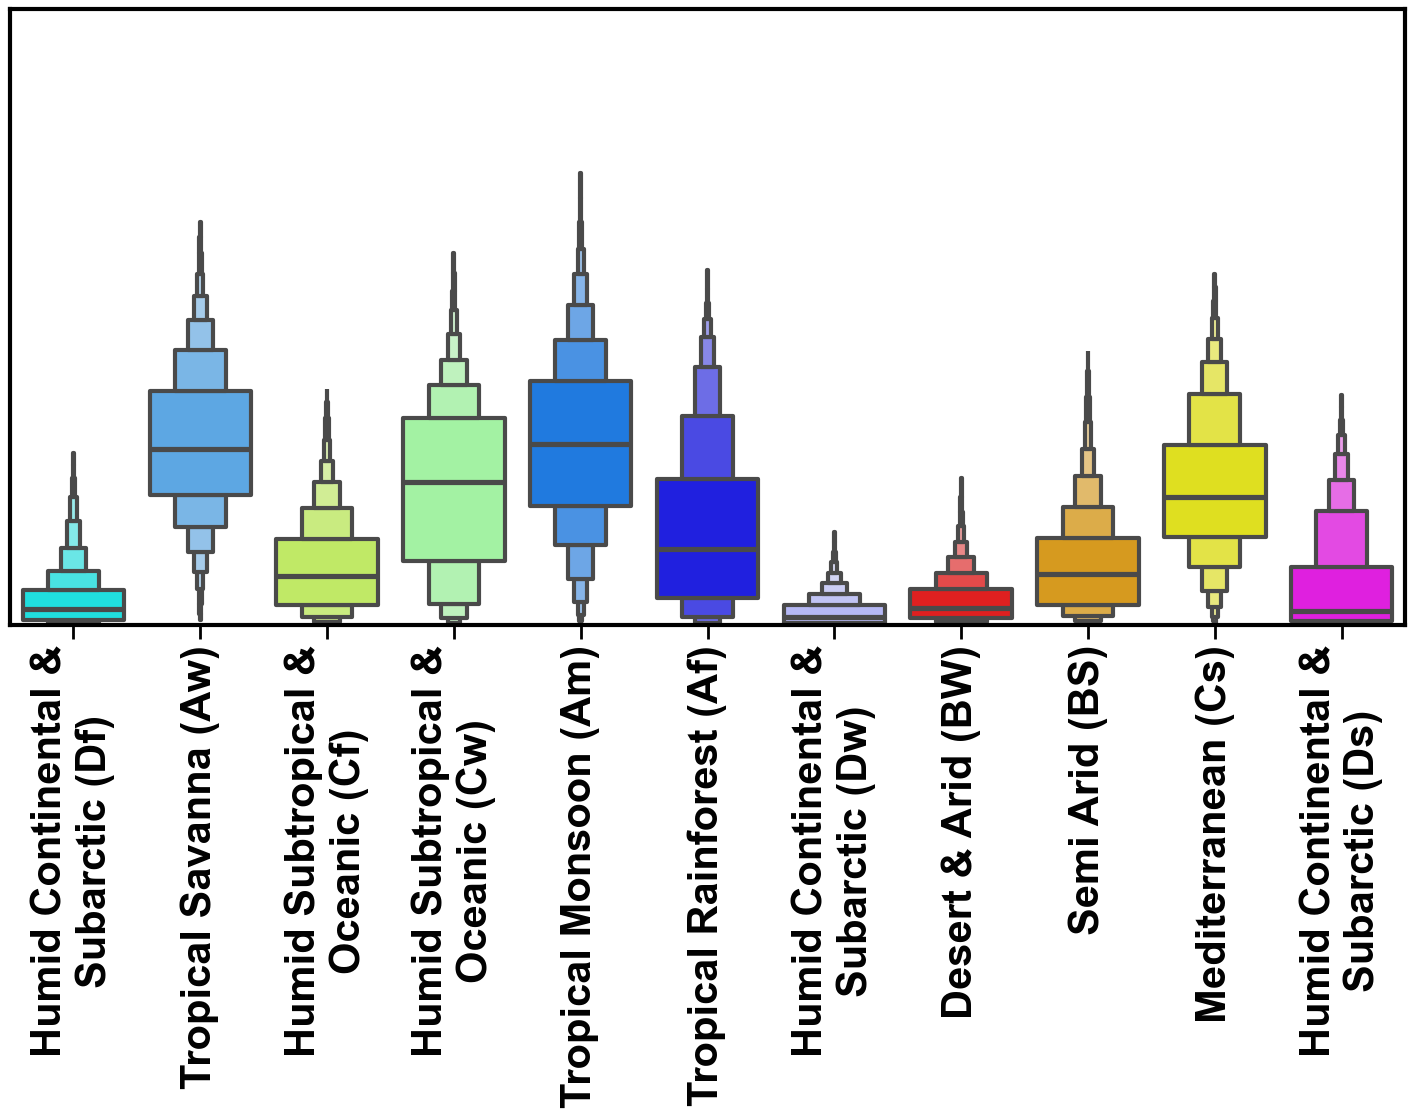

In [26]:
fig = plt.figure(figsize=(18, 8))

aesthetics_reorder_sorted = aesthetics_reorder.sort_values(by='number', ascending=True)
sns.boxenplot(x="Koppen_Together", y="Sbedrock", data=df_Koppen_sorted, linewidth=3,
              hue='Koppen_Together',palette=aesthetics_reorder_sorted['color'].unique(),
              order=aesthetics_reorder['number'].unique(),legend=False,    
              k_depth="proportion", outlier_prop=0.0078125, showfliers=False)
                
ax = plt.gca()

ax.tick_params(axis='x', which='major', length=10, width=2, direction='out')
ax.tick_params(axis='y', which='major', length=10, width=2, direction='out')

for spine in ax.spines.values():
    spine.set_edgecolor('black')  
    spine.set_linewidth(3)  

area_name = (aesthetics_reorder['area_sum'].unique()/1e9).round().astype(int)
print(area_name)

plt.xlabel('')  
plt.ylabel("")  

plt.xticks(ticks=(aesthetics_reorder.index), labels=aesthetics_reorder['name'].unique(), fontsize=30, fontweight='bold',rotation = 'vertical')

plt.ylim(0, 800)
yticks = np.arange(0, 900, 100)
# plt.yticks(ticks=yticks, labels=yticks,fontsize=30, fontweight='bold')
plt.yticks([])
plt.show()

In [27]:
## Check that no IGBP groups have less than 2km area
df_IGBP = df.copy()

df_IGBP = df_IGBP[df_IGBP['IGBP'] < 10]
df_IGBP = df_IGBP[df_IGBP['IGBP'] > 0]

igbp_area_sum = df_IGBP.groupby('IGBP')['Area'].sum().sort_values(ascending=False)

df_IGBP_reorder = df_IGBP.merge(igbp_area_sum, how='left', on='IGBP', suffixes=('', '_sum'))
df_IGBP_sorted = df_IGBP_reorder.sort_values(by='Area_sum', ascending=False)

lcoi = ['Evergreen Needleleaf\nForests','Evergreen Broadleaf\nForests',
        'Deciduous Needleleaf\nForests','Deciduous Broadleaf\nForests',
        'Mixed Forests',
        'Closed Shrublands','Open Shrublands',
        'Woody Savannas','Savannas','Grassland']
qgis_colors = ['#f8de85', '#FAC13E','#a5537f','#a52653',
               '#c04a02','#A4B381','#52B33F','#74B3B8',
               '#428ac8','#7846A8']
# qgis_colors = ['#05450a', '#086a10', '#54a708', '#78d203', 
#                 '#009900','#c6b044', '#dcd159', '#dade48',  
#                 '#fbff13']
IGBPList = ['Evergreen Needleleaf\nForests', 'Evergreen Broadleaf\nForests', 
            'Deciduous Needleleaf\nForests', 'Deciduous Broadleaf\nForests', 
            'Mixed Forests', 
            'Closed Shrublands', 'Open Shrublands', 
            'Woody Savannas', 'Savannas', 
            'Grasslands', 'Permanent Wetlands', 'Croplands', 
            'Urban and Built-up Lands', 'Cropland/Natural Vegetation Mosaics', 
            'Permanent Snow and Ice', 'Barren', 'Water Bodies']
land_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9,10]

land_aes = pd.DataFrame()
land_aes['name'] = lcoi
land_aes['number'] = land_numbers
land_aes['color'] = qgis_colors

IGBP_ids = df_IGBP['IGBP'].unique()
land_aesthetics = land_aes[land_aes.number.isin(IGBP_ids)]

land_aesthetics_reorder = land_aes[land_aes.number.isin(IGBP_ids)].copy()
land_aesthetics_reorder['Area_sum'] = land_aesthetics_reorder['number'].map(igbp_area_sum)
land_aesthetics_reorder = land_aesthetics_reorder.sort_values(by='Area_sum', ascending=False)
land_aesthetics_reorder.reset_index(drop=True, inplace=True)
land_aesthetics_reorder

name  number    color      Area_sum
0                       Savannas       9  #428ac8  6.541299e+12
1                 Woody Savannas       8  #74B3B8  4.923170e+12
2   Evergreen Broadleaf\nForests       2  #FAC13E  4.848233e+12
3                Open Shrublands       7  #52B33F  3.021386e+12
4                  Mixed Forests       5  #c04a02  2.414268e+12
5   Deciduous Broadleaf\nForests       4  #a52653  1.654552e+12
6  Evergreen Needleleaf\nForests       1  #f8de85  1.133955e+12
7  Deciduous Needleleaf\nForests       3  #a5537f  2.203484e+11
8              Closed Shrublands       6  #A4B381  7.458720e+10

/tmp/ipykernel_2391421/2309558732.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.boxenplot(x="IGBP", y="Sbedrock", data=df_IGBP_sorted, linewidth=3,


[6541 4923 4848 3021 2414 1655 1134  220   75]


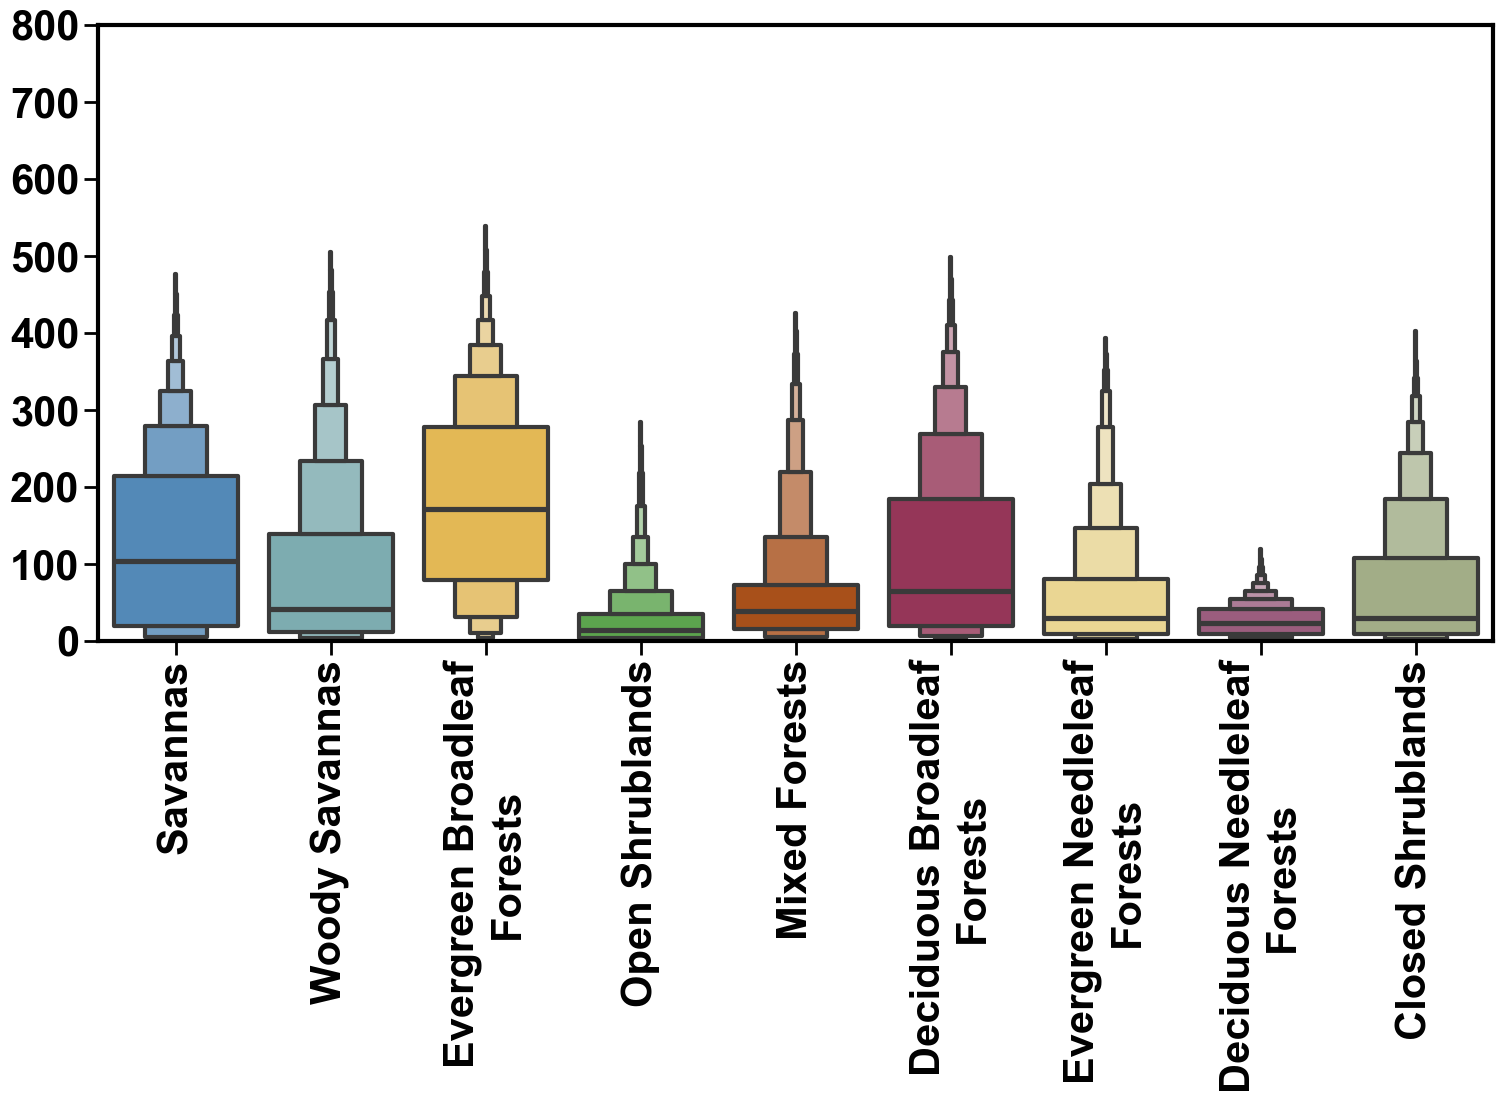

In [28]:
fig = plt.figure(figsize=(18, 8))

land_aesthetics_reorder_sorted = land_aesthetics_reorder.sort_values(by='number', ascending=True)
# print(land_aesthetics_reorder_sorted['color'].unique())
sns.boxenplot(x="IGBP", y="Sbedrock", data=df_IGBP_sorted, linewidth=3,
              hue='IGBP',palette=land_aesthetics_reorder_sorted['color'].unique(),
              order=land_aesthetics_reorder['number'].unique(), legend=False,
              k_depth="proportion", outlier_prop=0.0078125, showfliers=False)
      
ax = plt.gca()

ax.tick_params(axis='x', which='major', length=10, width=2, direction='out')
ax.tick_params(axis='y', which='major', length=10, width=2, direction='out')

for spine in ax.spines.values():
    spine.set_edgecolor('black')  
    spine.set_linewidth(3)  

area_name = (land_aesthetics_reorder['Area_sum'].unique()/1e9).round().astype(int)
print(area_name)

plt.xlabel('')  
plt.ylabel("")  

plt.xticks(ticks=(land_aesthetics_reorder.index), labels=land_aesthetics_reorder['name'].unique(), fontsize=30, fontweight='bold',rotation = 'vertical')

plt.ylim(0, 800)
yticks = np.arange(0, 900, 100)
plt.yticks(ticks=yticks, labels=yticks,fontsize=30, fontweight='bold')
plt.show()

### 2.4 Figs. 3d, 3e

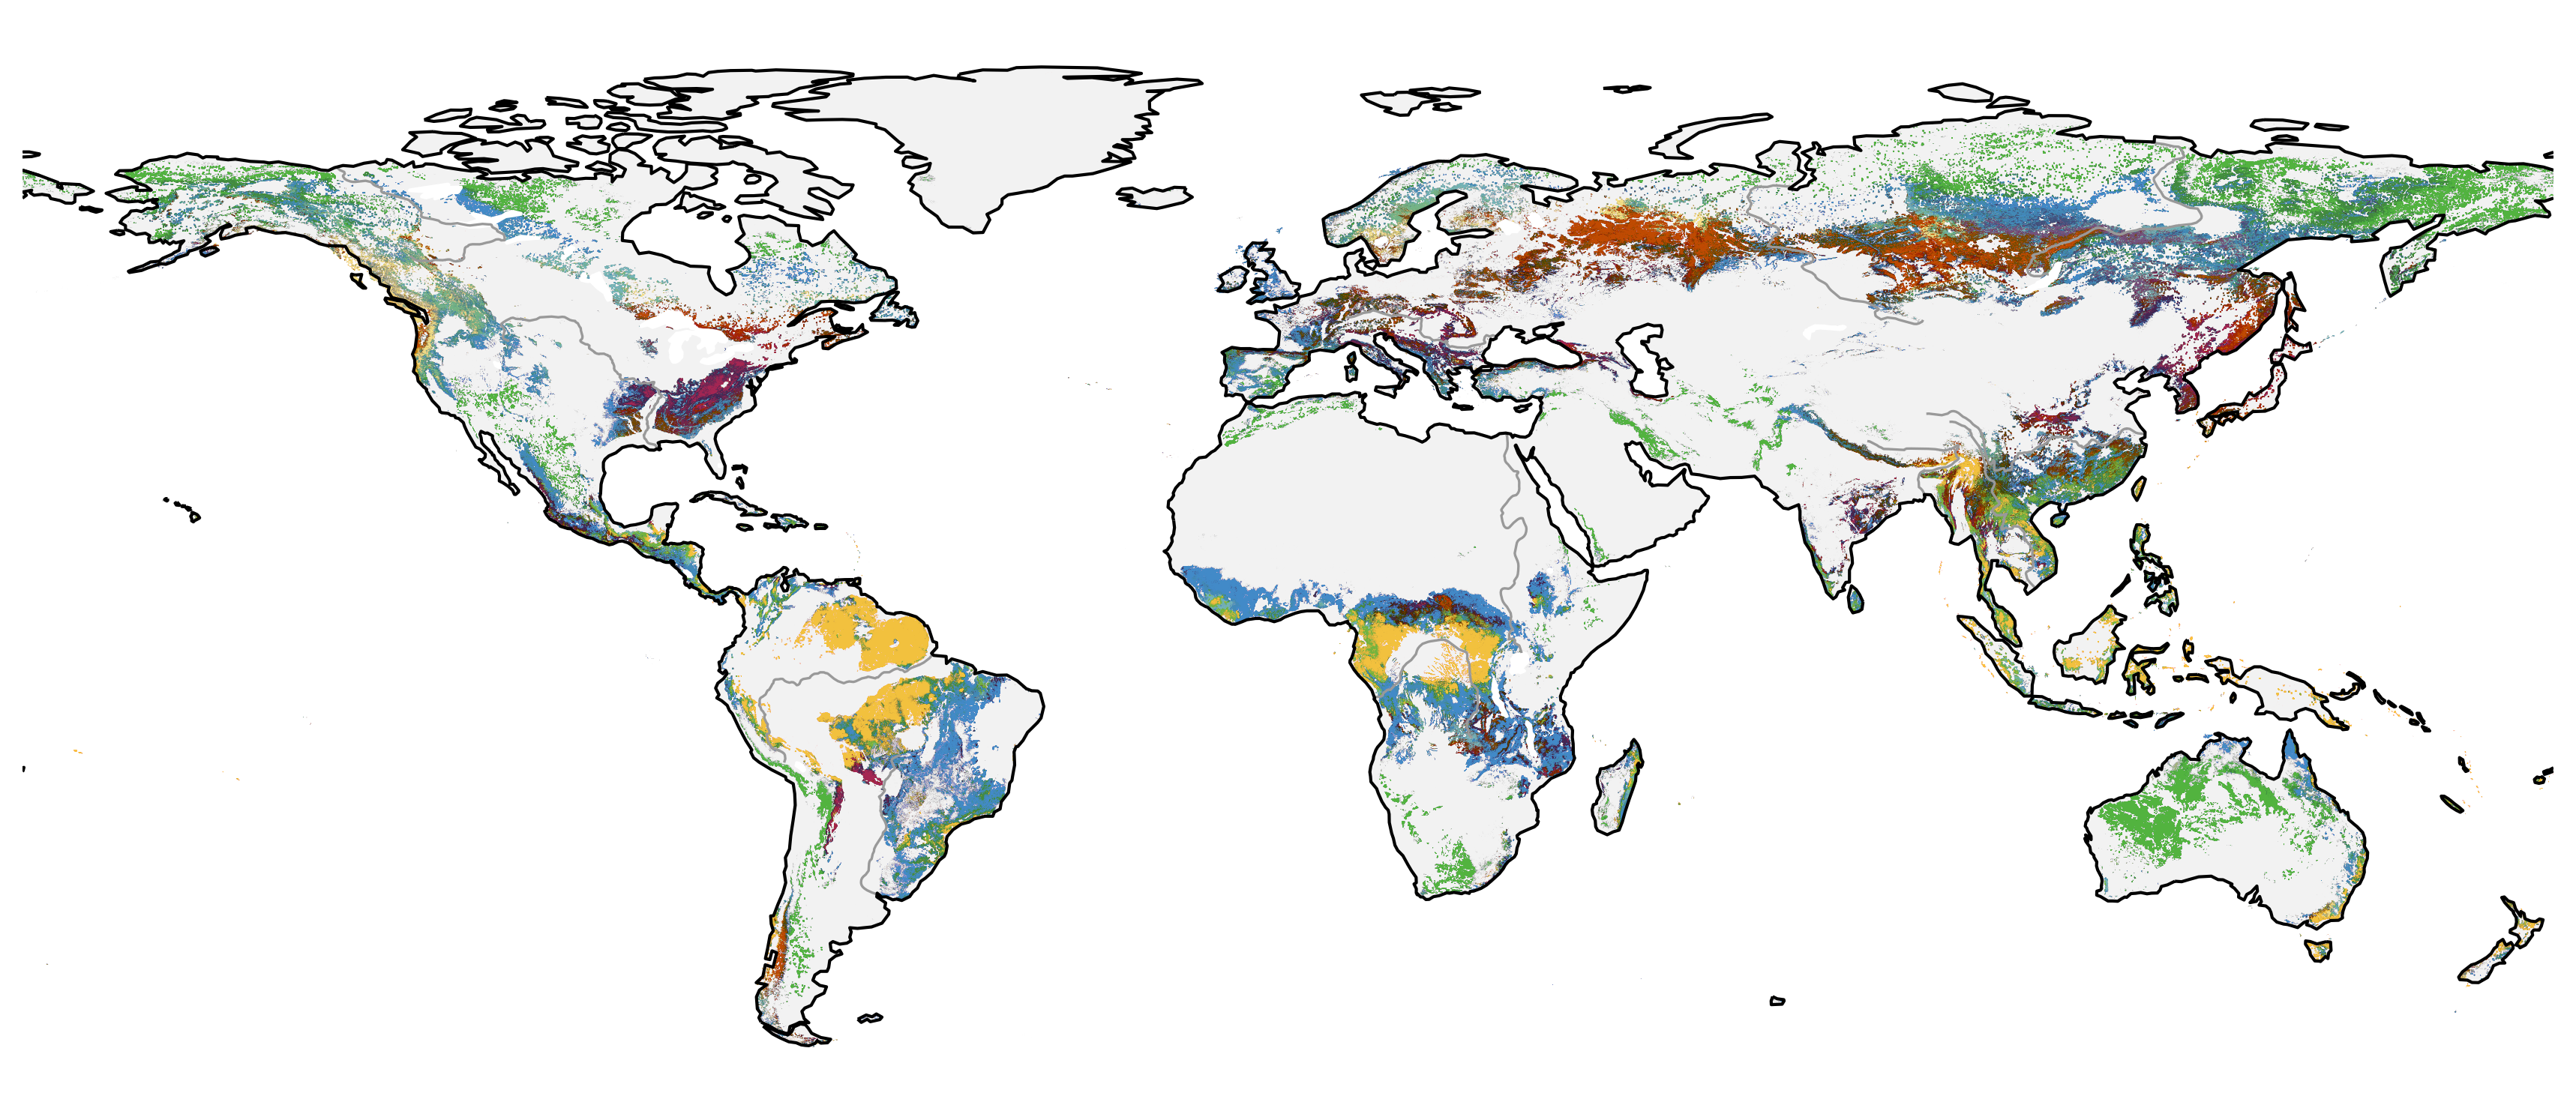

In [29]:
df1 = df.copy()

name = ['IGBP', 'LC', 'IGBP', 'IGBP']
level = np.arange(0.5,11.5,1)
# rgb_list = ['#05450a', '#086a10', '#54a708', '#78d203', 
#                 '#009900', '#c6b044', '#dcd159', '#dade48', 
#                 '#fbff13', '#b6ff05', '#27ff87','#c24f44', 
#                 '#a5a5a5', '#ff6d4c', '#69fff8', '#f9ffa4', '#1c0dff']
rgb_list = ['#f8de85', '#FAC13E','#a5537f','#a52653',
            '#c04a02','#A4B381','#52B33F','#74B3B8',
            '#428ac8','#7846A8']
cmap = colors.ListedColormap(rgb_list)
draw(df1,name,level,cmap)

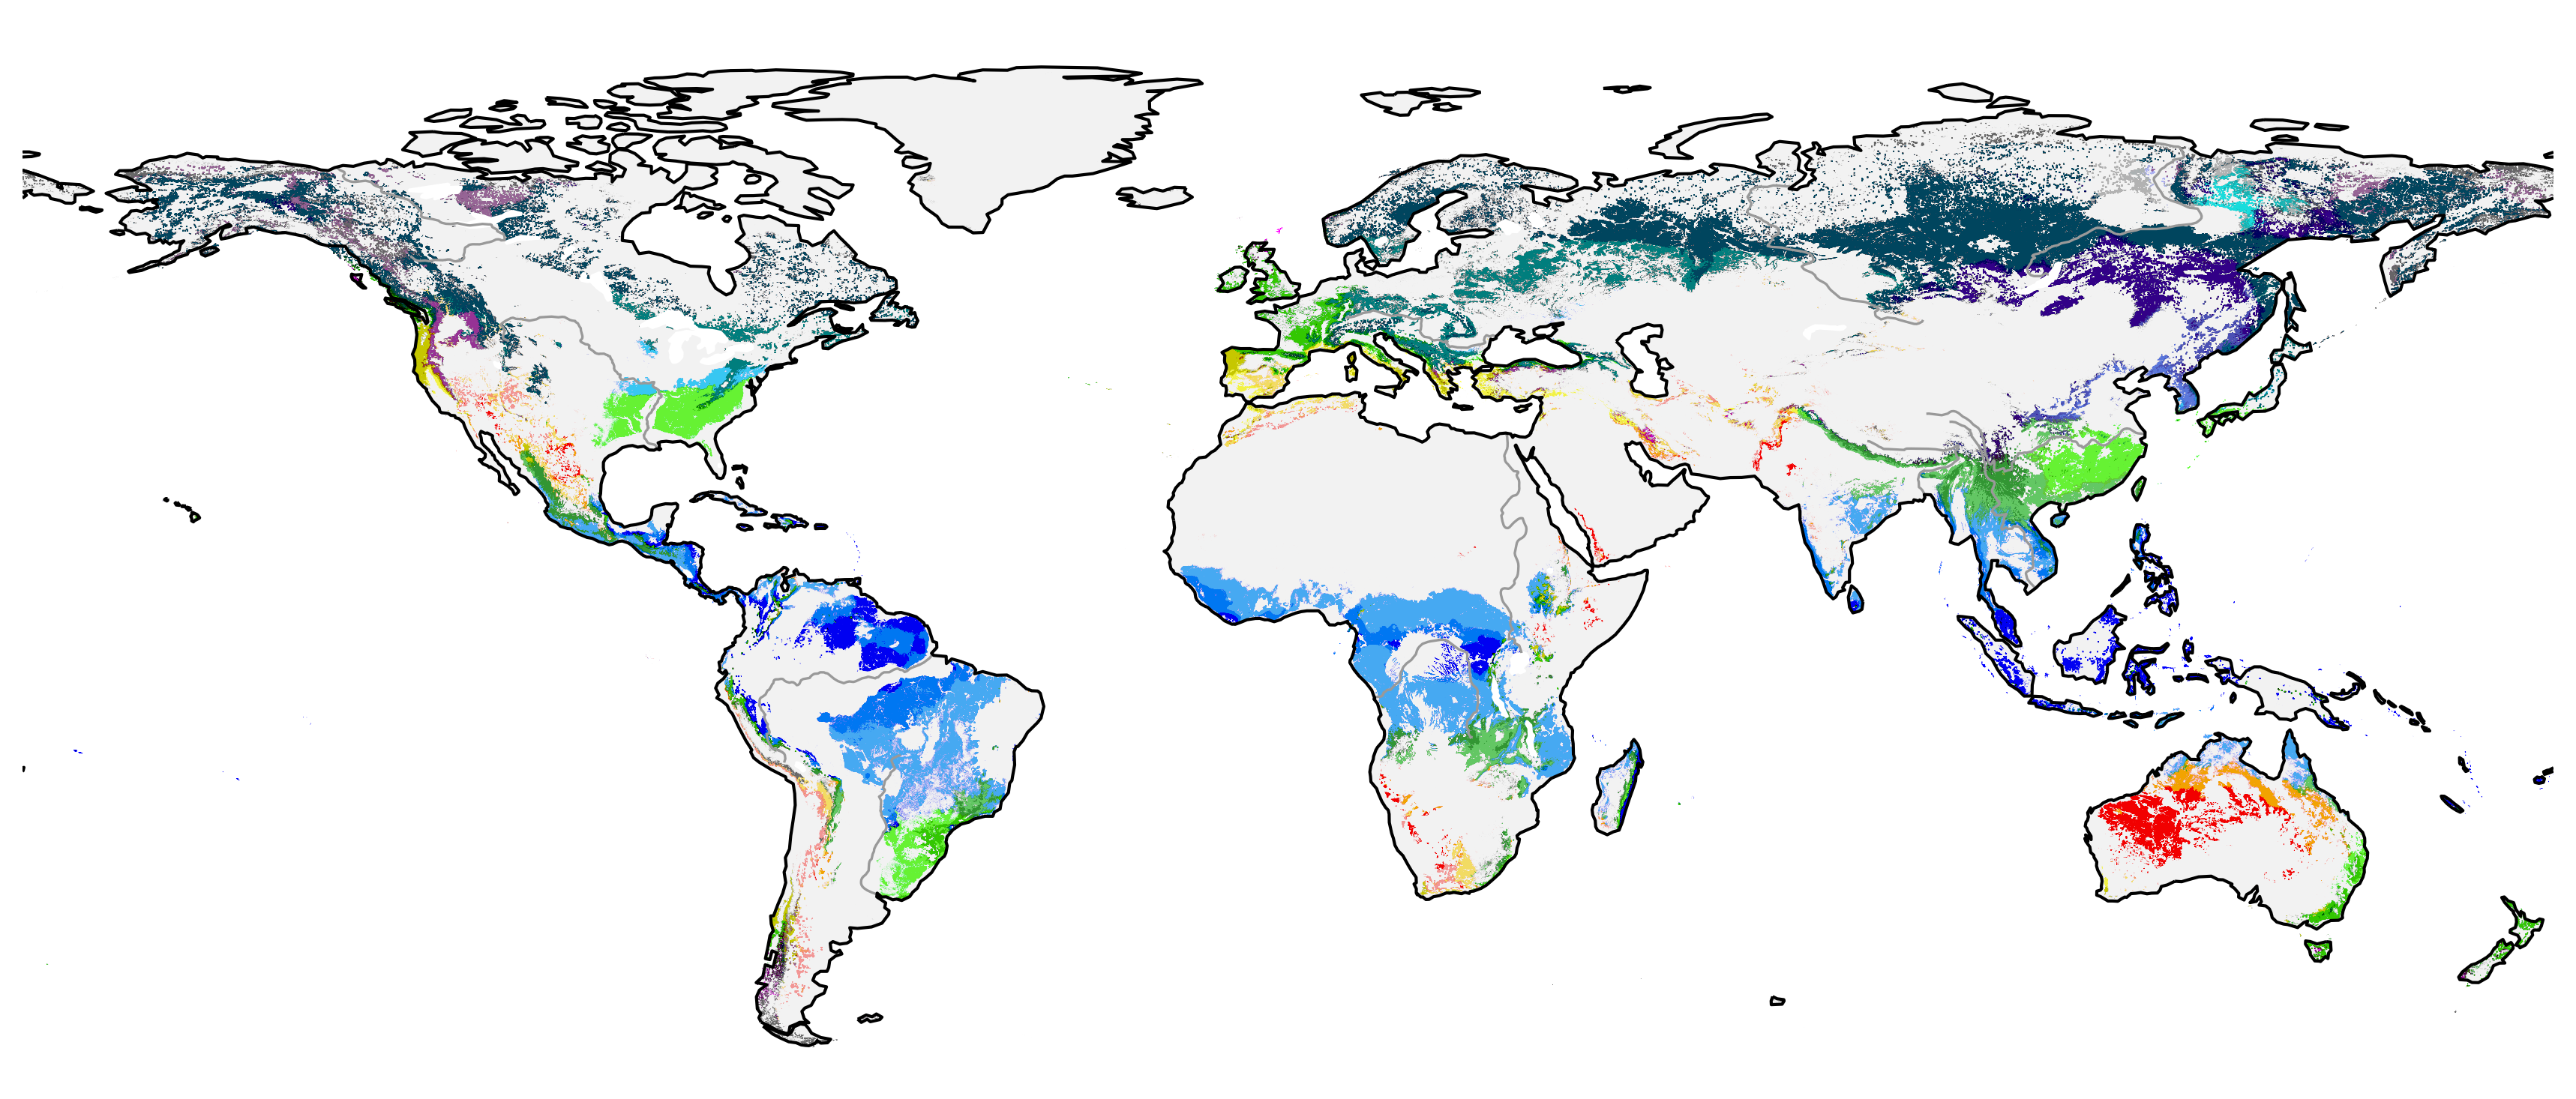

In [30]:
df1 = df.copy()

name = ['Koppen', 'Band1', 'Koppen', 'Koppen']
level = np.arange(0,31,1)
rgb_list = ['#ffffff','#0000FE','#0077FF','#46A9FA','#FE0000',
            '#FE9695','#F5A301','#FFDB63','#FDFD45','#C6C700',
            '#96FF96','#63C764','#329633','#C6FF4E','#66FF33',
            '#33C701','#FF00FE','#C600C7','#963295','#966495',
            '#ABB1FF','#5A77DB','#4C51B5','#320087','#18DCDC',
            '#38C7FF','#007E7D','#00455E','#B2B2B2','#686868']
cmap = colors.ListedColormap(rgb_list)

df1['Koppen_Together'] = df1['Koppen'].replace(to_replace=[5, 7, 9, 10, 12, 13, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28], value=[4, 6, 8, 8, 11, 11, 14, 14, 17, 17, 17, 21, 21, 21, 25, 25, 25])
draw(df1,name,level,cmap)